# CNN + LSTM + Dense 
Before adding attention layers, establish the most we can do with Dense layers.

In [1]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2022-12-19 17:24:06.483469
Python 3.8.16
sklearn 1.0.2


We prevously used sklearn.model_selection.ShuffleSplit   
Now we avoid it due to this note in the 
[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html):
Note: contrary to other cross-validation strategies, random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.

In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import Flatten
from keras.layers import Attention
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
RCI_THRESHOLD=0.0
CFILTERS=64
FILTERSIZE=8
RCELLS=16
DCELLS=8
EPOCHS=5
FOLDS=5      
EMBED_DIMEN = 4 # arbitrary hyperparameter
BREAK = False   # break after first fold
MINLEN=2000
MAXLEN=4000   

In [3]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'    # Mac
print(DATA_DIR)

Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/


In [4]:
GENES_FILE =    'CNRCI_coding_train_genes.csv'
RCI_FILE =      'CNRCI_coding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_coding_train_transcripts.gc42.csv'
COUNTS_FILE=    'CNRCI_coding_train_counts.K4.gc42.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549',\
      'H1.hESC',\
      'HeLa.S3',\
      'HepG2',\
      'HT1080',\
      'HUVEC',\
      'MCF.7',\
      'NCI.H460',\
      'NHEK',\
      'SK.MEL.5',\
      'SK.N.DZ',\
      'SK.N.SH',\
      'GM12878',\
      'K562',\
      'IMR.90']
    return ordered_list
CELL_LINE_NUMBER=1
all_cell_lines = get_ordered_list()
cell_line_name = all_cell_lines[CELL_LINE_NUMBER]
print('Cell line for today:',CELL_LINE_NUMBER,'=',cell_line_name)

Cell line for today: 1 = H1.hESC


## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        
    def load_gene_rci_values(self,filepath,cell_line):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields[0]
                    rci_val = fields[cell_line+1]
                    if rci_val != "nan":
                        # Convert string nan to float(nan)
                        gene_to_rci[gene_id] = float(rci_val)
        return gene_to_rci
    
    def seq_to_kmer_values(self,rna,K):
        # The cache may represent more than one K. Probably not a problem.
        N_indicator = 0 # indicator value
        vec=[] # seq converted to list of K-mers 
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def rci_to_label(self,rci):
        CYTO_LABEL = 1
        NUCLEAR_LABEL = 0
        # cnrci = log (cyto-to-nuclear ratio)
        # rci > 0 implies cytoplasmic
        if rci > RCI_THRESHOLD:
            return CYTO_LABEL
        return NUCLEAR_LABEL

    def load_sequence(self,filepath):
        labels=[]
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # with version number
                    gene_id = fields[1]        # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                        allids.append( (gene_id,tran_id) )
                        rci_val = gene_to_rci[gene_id]
                        rci_label = self.rci_to_label(rci_val)
                        labels.append(rci_label)
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self.seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        return labels,allids,allseq
    
loader = DataLoader()
# test it
print(loader.seq_to_kmer_values('AAAA',3))
print(loader.seq_to_kmer_values('CATT',3))
print(loader.seq_to_kmer_values('TTGA',3))
print(loader.seq_to_kmer_values('TTTN',3))
# test it
print(loader.rci_to_label(-0.9))
print(loader.rci_to_label(1.1))

[1, 1]
[20, 16]
[63, 57]
[64, 0]
0
1


In [7]:
print(datetime.now())
print("Load RCI values...")
loader = DataLoader()
filepath = DATA_DIR+RCI_FILE
gene_to_rci = loader.load_gene_rci_values(filepath,CELL_LINE_NUMBER)
print('Num RCI:', len(gene_to_rci.keys()))
print('Example RCI:', list(gene_to_rci.items())[:3])
print("Load genes...")
all_genes = list(gene_to_rci.keys())
print(datetime.now())
print('Load sequence...')
filepath = DATA_DIR+SEQUENCE_FILE
labels,allids,allseq = loader.load_sequence(filepath)
print(datetime.now())
print('Num IDs:',len(allids))
print('Example IDs:',[allids[x] for x in [10, 20, 30, 40]] )
print('Count',np.count_nonzero(labels),'ones out of',len(labels),'labels.')
print('Example labels:',[labels[x] for x in [10, 20, 30, 40]] )
print('Num counts:',len(allseq))
print('Example sequence:',allseq[3])
loader = None  # drop K-mer cache to save RAM

2022-12-19 17:24:31.450361
Load RCI values...
Num RCI: 13000
Example RCI: [('ENSG00000000003', 1.85734), ('ENSG00000000005', 5.88264), ('ENSG00000000419', 2.58954)]
Load genes...
2022-12-19 17:24:32.032663
Load sequence...
2022-12-19 17:24:57.994666
Num IDs: 18084
Example IDs: [('ENSG00000162571', 'ENST00000379289.6'), ('ENSG00000131584', 'ENST00000354700.10'), ('ENSG00000162576', 'ENST00000477278.3'), ('ENSG00000197530', 'ENST00000505820.7')]
Count 8030 ones out of 18084 labels.
Example labels: [0, 0, 0, 0]
Num counts: 18084
Example sequence: [60, 238, 182, 213, 81, 67, 11, 43, 171, 169, 164, 142, 54, 216, 95, 122, 229, 147, 75, 44, 175, 186, 229, 148, 78, 54, 216, 94, 118, 215, 89, 100, 142, 56, 223, 122, 231, 153, 98, 136, 31, 122, 230, 150, 87, 91, 107, 170, 168, 159, 122, 230, 151, 89, 97, 132, 13, 52, 206, 54, 216, 94, 118, 214, 86, 87, 91, 108, 175, 185, 225, 130, 6, 23, 91, 107, 171, 171, 170, 167, 155, 106, 168, 159, 123, 234, 165, 147, 73, 34, 133, 17, 67, 9, 35, 139, 41, 162

## Model

In [8]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    rnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    #rnn1_layer = Bidirectional( LSTM(RCELLS, return_sequences=False) )
    #pool_layer = MaxPooling1D(pool_size=3)
    pool_layer = GlobalAveragePooling1D()
    flat_layer = Flatten()
    den1_layer = Dense(DCELLS)
    drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    rnn.add(embed_layer)
    rnn.add(cnn1_layer)
    rnn.add(pool_layer)
    #rnn.add(flat_layer)
    #rnn.add(den1_layer)
    #rnn.add(drop_layer)
    rnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    print("COMPILE")
    rnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return rnn

In [9]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once

2022-12-19 17:24:58.035461
COMPILE
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3997, 4)           1028      
                                                                 
 conv1d (Conv1D)             (None, 3990, 64)          2112      
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 3,205
Trainable params: 3,205
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [10]:
class CrossValidator():
    def __init__(self,epochs,folds,quick_test=False,pred_threshold=0.5):
        self.epochs = epochs
        self.folds = folds
        self.quick_test = quick_test
        self.threshold = pred_threshold # e.g. score>0.5 => class 1
    
    def get_gene_subset(self,all_genes,sub_index):
        sub_genes = set()
        for index in sub_index:
            one_gene = all_genes[index]
            sub_genes.add(one_gene)
        return sub_genes
    
    def get_X_y(self,gene_set,allids,allX,allY):
        cnt = len(allids)
        subsetX=[]
        subsetY=[]
        if cnt != len(allX) or cnt!= len(allY):
            raise Exception('Lengths differ')
        for i in range(cnt):
            gene_id,tran_id = allids[i]
            if gene_id in gene_set:
                oneX = allX[i]
                oneY = allY[i]
                subsetX.append(oneX)
                subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def do_cross_validation(self):
        cv_accuracy=[]
        cv_precision=[]
        cv_recall=[]
        cv_f1=[]
        fold=0
        print(datetime.now())
        print('splitting')
        # KFold shuffles once before making the partitions
        splitter = KFold(n_splits=self.folds,shuffle=True,random_state=42)
        for train_index,valid_index in splitter.split(all_genes):
            fold += 1
            print('Fold',fold)
            train_genes = self.get_gene_subset(all_genes,train_index)
            valid_genes = self.get_gene_subset(all_genes,valid_index)
            X_train,y_train = self.get_X_y(train_genes,allids,allseq,labels)
            X_valid,y_valid = self.get_X_y(valid_genes,allids,allseq,labels)

            print('Training example')
            print(X_train[0])

            print('Train sizes',X_train.shape,y_train.shape)
            print('Valid sizes',X_valid.shape,y_valid.shape)
            print('Train set ones/size',
                  np.count_nonzero(y_train),'/',len(y_train))
            print('Valid set ones/size',
                  np.count_nonzero(y_valid),'/',len(y_valid))

            print("BUILD MODEL")
            model=build_model()

            print("FIT")
            print(datetime.now())
            history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                    epochs=self.epochs, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                    validation_data=(X_valid,y_valid) )

            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()

            print("Compute valiation accuracy")
            print(datetime.now())
            yhat_pred=model.predict(X_valid, verbose=0) 
            print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
            yhat_classes=np.where(yhat_pred > self.threshold, 1, 0)
            print('Predicted zeros and ones',np.count_nonzero(yhat_classes==0),np.count_nonzero(yhat_classes==1))
            # accuracy: (tp + tn) / (p + n)
            accuracy = accuracy_score(y_valid, yhat_classes)*100.
            # precision tp / (tp + fp)
            precision = precision_score(y_valid, yhat_classes)*100.
            # recall: tp / (tp + fn)
            recall = recall_score(y_valid, yhat_classes)*100.
            # f1: 2 tp / (2 tp + fp + fn)
            f1 = f1_score(y_valid, yhat_classes)*100.
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%% F1: %.2f%%' % (accuracy,precision,recall,f1)) 
            print(datetime.now())
            cv_accuracy.append(accuracy)
            cv_precision.append(precision)
            cv_recall.append(recall)
            cv_f1.append(f1)
            if self.quick_test:   
                print('Break -- this was for code testing only')
                break
        print()
        return cv_accuracy, cv_precision, cv_recall, cv_f1

2022-12-19 17:25:01.319753
2022-12-19 17:25:01.320357
splitting
Fold 1
Training example
[167 155 106 ...   0   0   0]
Train sizes (14388, 3997) (14388, 1)
Valid sizes (3696, 3997) (3696, 1)
Train set ones/size 6390 / 14388
Valid set ones/size 1640 / 3696
BUILD MODEL
COMPILE
FIT
2022-12-19 17:25:05.309834
Epoch 1/5
450/450 [==============================] - 13s 8ms/step - loss: 0.5681 - accuracy: 0.7067 - val_loss: 0.5379 - val_accuracy: 0.7240
Epoch 2/5
450/450 [==============================] - 3s 7ms/step - loss: 0.5329 - accuracy: 0.7387 - val_loss: 0.5364 - val_accuracy: 0.7338
Epoch 3/5
450/450 [==============================] - 3s 7ms/step - loss: 0.5226 - accuracy: 0.7487 - val_loss: 0.5182 - val_accuracy: 0.7446
Epoch 4/5
450/450 [==============================] - 3s 7ms/step - loss: 0.5141 - accuracy: 0.7526 - val_loss: 0.5148 - val_accuracy: 0.7516
Epoch 5/5
450/450 [==============================] - 3s 7ms/step - loss: 0.5089 - accuracy: 0.7573 - val_loss: 0.5156 - val_accur

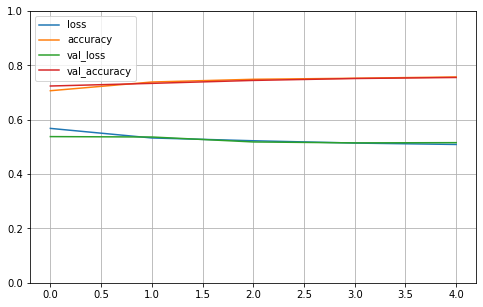

Compute valiation accuracy
2022-12-19 17:25:47.887464
Range of scores: 0.0043965904 to 0.97327596
Predicted zeros and ones 2270 1426
Accuracy: 75.54% Precision: 75.81% Recall: 65.91% F1: 70.52%
2022-12-19 17:25:48.732052
Fold 2
Training example
[167 155 106 ...   0   0   0]
Train sizes (14453, 3997) (14453, 1)
Valid sizes (3631, 3997) (3631, 1)
Train set ones/size 6483 / 14453
Valid set ones/size 1547 / 3631
BUILD MODEL
COMPILE
FIT
2022-12-19 17:25:52.684041
Epoch 1/5
452/452 [==============================] - 4s 8ms/step - loss: 0.5707 - accuracy: 0.7018 - val_loss: 0.5282 - val_accuracy: 0.7461
Epoch 2/5
452/452 [==============================] - 3s 7ms/step - loss: 0.5335 - accuracy: 0.7376 - val_loss: 0.5349 - val_accuracy: 0.7397
Epoch 3/5
452/452 [==============================] - 3s 7ms/step - loss: 0.5232 - accuracy: 0.7455 - val_loss: 0.5089 - val_accuracy: 0.7604
Epoch 4/5
452/452 [==============================] - 3s 8ms/step - loss: 0.5141 - accuracy: 0.7553 - val_loss: 0.5

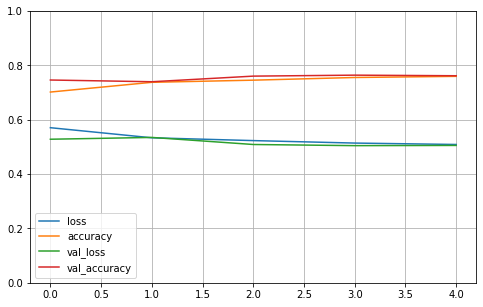

Compute valiation accuracy
2022-12-19 17:26:14.220536
Range of scores: 0.0021712943 to 0.96290094
Predicted zeros and ones 1943 1688
Accuracy: 76.18% Precision: 70.20% Recall: 76.60% F1: 73.26%
2022-12-19 17:26:14.985878
Fold 3
Training example
[167 155 106 ...   0   0   0]
Train sizes (14355, 3997) (14355, 1)
Valid sizes (3729, 3997) (3729, 1)
Train set ones/size 6379 / 14355
Valid set ones/size 1651 / 3729
BUILD MODEL
COMPILE
FIT
2022-12-19 17:26:18.990455
Epoch 1/5
449/449 [==============================] - 4s 8ms/step - loss: 0.5670 - accuracy: 0.6991 - val_loss: 0.5394 - val_accuracy: 0.7420
Epoch 2/5
449/449 [==============================] - 3s 7ms/step - loss: 0.5295 - accuracy: 0.7388 - val_loss: 0.5307 - val_accuracy: 0.7514
Epoch 3/5
449/449 [==============================] - 3s 8ms/step - loss: 0.5179 - accuracy: 0.7507 - val_loss: 0.5267 - val_accuracy: 0.7581
Epoch 4/5
449/449 [==============================] - 3s 7ms/step - loss: 0.5103 - accuracy: 0.7538 - val_loss: 0.5

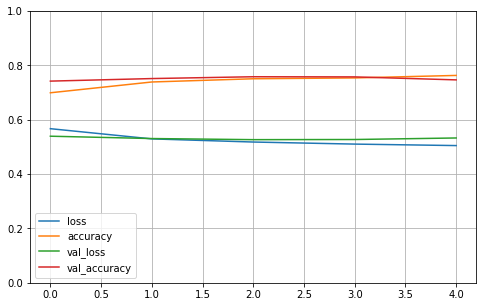

Compute valiation accuracy
2022-12-19 17:26:40.827841
Range of scores: 0.00094954413 to 0.9811149
Predicted zeros and ones 2375 1354
Accuracy: 74.66% Precision: 76.07% Recall: 62.39% F1: 68.55%
2022-12-19 17:26:41.579483
Fold 4
Training example
[167 155 106 ...   0   0   0]
Train sizes (14515, 3997) (14515, 1)
Valid sizes (3569, 3997) (3569, 1)
Train set ones/size 6471 / 14515
Valid set ones/size 1559 / 3569
BUILD MODEL
COMPILE
FIT
2022-12-19 17:26:45.495707
Epoch 1/5
454/454 [==============================] - 4s 8ms/step - loss: 0.5681 - accuracy: 0.7030 - val_loss: 0.5405 - val_accuracy: 0.7291
Epoch 2/5
454/454 [==============================] - 3s 7ms/step - loss: 0.5295 - accuracy: 0.7430 - val_loss: 0.5416 - val_accuracy: 0.7150
Epoch 3/5
454/454 [==============================] - 3s 7ms/step - loss: 0.5198 - accuracy: 0.7514 - val_loss: 0.5307 - val_accuracy: 0.7461
Epoch 4/5
454/454 [==============================] - 3s 7ms/step - loss: 0.5128 - accuracy: 0.7561 - val_loss: 0.5

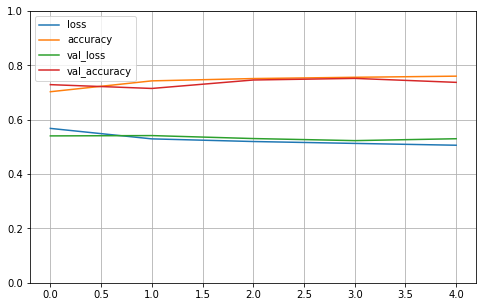

Compute valiation accuracy
2022-12-19 17:27:06.866108
Range of scores: 0.0006252097 to 0.9827267
Predicted zeros and ones 2307 1262
Accuracy: 73.75% Precision: 74.64% Recall: 60.42% F1: 66.78%
2022-12-19 17:27:07.309404
Fold 5
Training example
[160 126 247 ...   0   0   0]
Train sizes (14625, 3997) (14625, 1)
Valid sizes (3459, 3997) (3459, 1)
Train set ones/size 6397 / 14625
Valid set ones/size 1633 / 3459
BUILD MODEL
COMPILE
FIT
2022-12-19 17:27:11.234791
Epoch 1/5
458/458 [==============================] - 4s 8ms/step - loss: 0.5686 - accuracy: 0.7013 - val_loss: 0.5451 - val_accuracy: 0.7308
Epoch 2/5
458/458 [==============================] - 3s 7ms/step - loss: 0.5306 - accuracy: 0.7419 - val_loss: 0.5307 - val_accuracy: 0.7378
Epoch 3/5
458/458 [==============================] - 3s 8ms/step - loss: 0.5190 - accuracy: 0.7512 - val_loss: 0.5208 - val_accuracy: 0.7456
Epoch 4/5
458/458 [==============================] - 3s 8ms/step - loss: 0.5124 - accuracy: 0.7565 - val_loss: 0.52

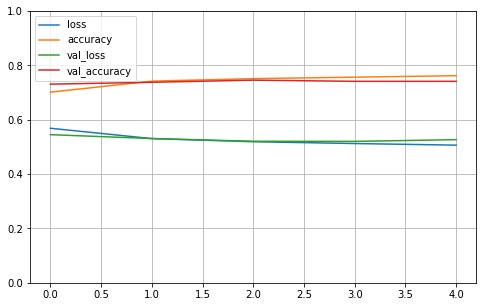

Compute valiation accuracy
2022-12-19 17:27:32.569990
Range of scores: 0.00297543 to 0.9702349
Predicted zeros and ones 2025 1434
Accuracy: 74.13% Precision: 75.73% Recall: 66.50% F1: 70.82%
2022-12-19 17:27:33.322195

Cross validation 5 folds 5 epochs
 accuracy mean 74.85% +/- 0.90
 precision mean 74.49% +/- 2.20
 recall mean 66.37% +/- 5.59
 F1 mean 69.99% +/- 2.19
2022-12-19 17:27:33.325581


In [11]:
print(datetime.now())
cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
cv_accuracy, cv_precision, cv_recall, cv_f1 = cvdo.do_cross_validation()   
print("Cross validation %d folds %d epochs" % (FOLDS,EPOCHS)) 
print(" accuracy mean %.2f%% +/- %.2f" % (np.mean(cv_accuracy), np.std(cv_accuracy)))
print(" precision mean %.2f%% +/- %.2f" % (np.mean(cv_precision), np.std(cv_precision)))
print(" recall mean %.2f%% +/- %.2f" % (np.mean(cv_recall), np.std(cv_recall)))
print(" F1 mean %.2f%% +/- %.2f" % (np.mean(cv_f1), np.std(cv_f1)))
print(datetime.now())